### Loading Required Libraries

In [3]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Sequential,Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow import keras

In [4]:
from sklearn.model_selection import train_test_split              
from tqdm import tqdm
from keras import optimizers
from keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

#### Setting up directories

In [5]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [6]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

### Data Preparation

Create csv files for the training and testing data 

In [7]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
#create_csv(TEST_DIR,"test.csv")


In [8]:
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_train
#data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

,Filename,ClassName
0,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c0
1,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c0
2,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c0
3,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c0
4,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c0
...,...,...
22419,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c9
22420,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c9
22421,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c9
22422,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,c9


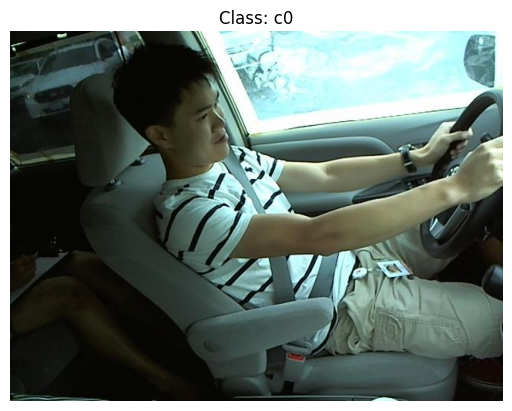

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the CSV file into a DataFrame

# Select an instance to view (e.g., the first row)
sample_instance = data_train.loc[4, "Filename"]

# Display the image
img = mpimg.imread(sample_instance)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.title(f"Class: {data_train.loc[4, 'ClassName']}")
plt.show()


In [10]:
data_train['ClassName'].value_counts()

ClassName
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

### Looking at the class distribution

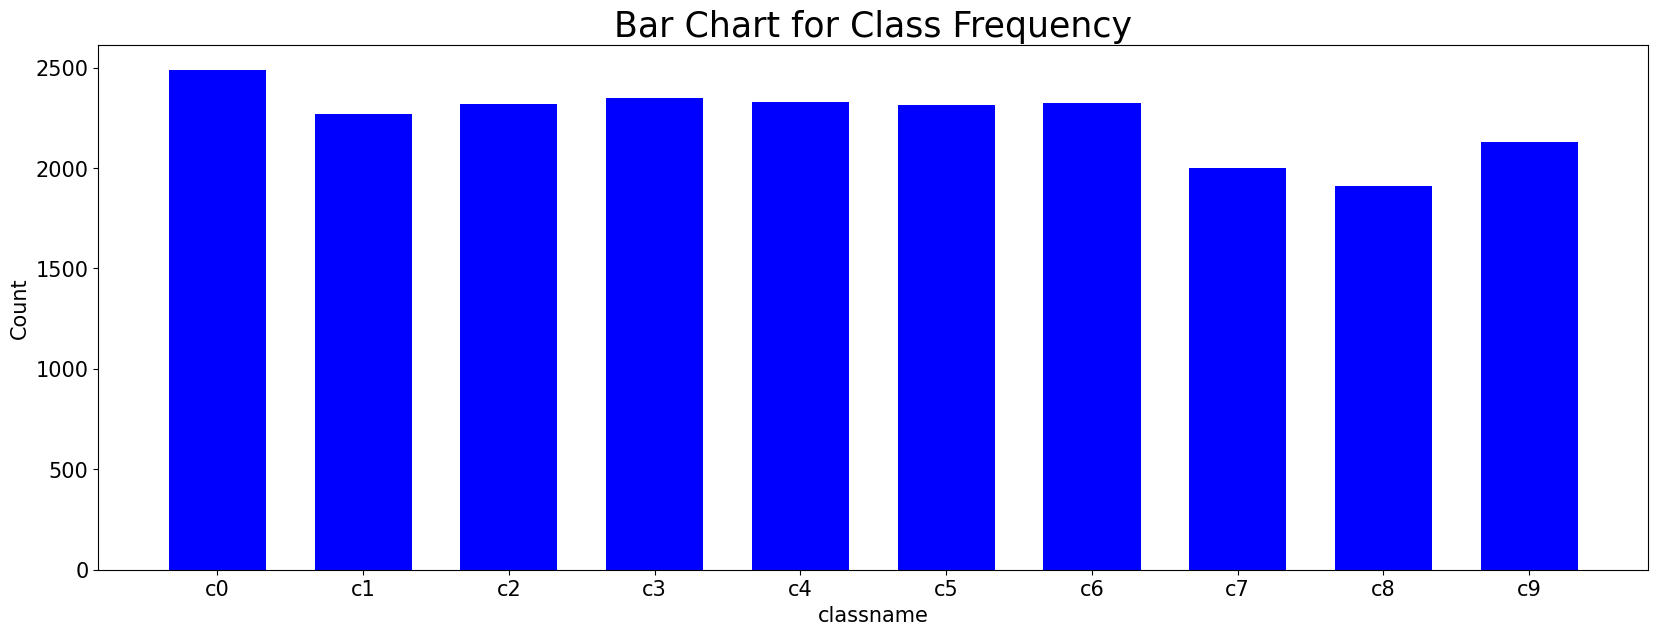

In [11]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart for Class Frequency',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [12]:
# data_test.shape

In [13]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_list

['c9', 'c5', 'c1', 'c7', 'c8', 'c3', 'c0', 'c2', 'c6', 'c4']

In [14]:
labels_list = sorted(labels_list)  # Sort the list alphabetically
for id,label_name in enumerate(labels_list):
    print(id,label_name)

0 c0
1 c1
2 c2
3 c3
4 c4
5 c5
6 c6
7 c7
8 c8
9 c9


In [15]:
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}


In [16]:
labels_id

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [17]:
data_train['ClassName'].replace(labels_id, inplace=True)


In [18]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

#### Converting the labels to one-hot vector before passing into the model

In [19]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


In [20]:
labels = np.array(labels)

In [21]:
# import pandas as pd
# import cv2
# import numpy as np

# # Load the CSV file into a DataFrame
#   # Replace "train.csv" with the actual path to your CSV file

# # Initialize constants
# image_size = (64, 64)  # Adjust this size as needed

# # Initialize empty NumPy arrays to store images and labels
# X_train = np.empty((len(data_train), *image_size, 3), dtype=np.uint8)
# y_train = np.empty(len(data_train), dtype=int)



In [22]:
data_train

,Filename,ClassName
0,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
1,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
2,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
3,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
4,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
...,...,...
22419,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
22420,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
22421,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
22422,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import numpy as np

# Load your dataset
 # Adjust the filename as necessary

# Split the dataset into training and testing sets (75:25 split)
train_df, test_df = train_test_split(data_train, test_size=0.25, random_state=42)

# Now, train_data and test_data are DataFrames containing your split data.
# You would process images in each subset similarly to how you intended for X_train.
train_df

,Filename,ClassName
21996,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
7558,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,3
22160,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
729,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0
22326,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
...,...,...
11964,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,5
21575,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,9
5390,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,2
860,C:\Users\Gunjan Joshi\Documents\Distracted Dri...,0


In [24]:
# for i, row in train_data.iterrows():
#     image_path = row['Filename']  # Assuming "Filename" is the column name with image paths
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, image_size)
#     X_train[i, :, :, :] = img.astype(np.float32)  # Convert to float32
#     y_train[i] = row['ClassName']  # Assuming "ClassName" is the column name with class labels

# # Reshape X_train to add the batch dimension
# X_train = X_train.reshape(-1, *image_size, 3)

In [25]:
# X_train

#### Applying Data Augmentation

In [24]:
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [25]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [26]:
def change_contrast(img, level):
    img = Image.fromarray(img.astype('uint8'))
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return np.array(img.point(contrast))


In [27]:
def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img

In [28]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_EPOCH = 25

In [29]:
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.2,
        preprocessing_function = preprocess_img)

In [30]:
#TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
# TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
# TRAIN_DIR

In [31]:
train_df['ClassName'] = train_df['ClassName'].astype(str)

In [32]:
#use dataframe directly instead of using directory 
train_data = datagen.flow_from_dataframe(directory=None,
                                         dataframe = train_df,
                                         x_col='Filename',  # Column in dataframe that contains the filenames 
                                         y_col='ClassName',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=True,
                                        seed = 42)

valid_data = datagen.flow_from_dataframe(directory = None,
                                         dataframe = train_df,
                                         x_col='Filename',  # Column in dataframe that contains the filenames 
                                         y_col='ClassName',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=True,
                                        seed = 42)

Found 13455 validated image filenames belonging to 10 classes.
Found 3363 validated image filenames belonging to 10 classes.


### Model Building 

## Building a CNN model from scratch

In [33]:
model = Sequential()
#use glorot normal to avoid vanishing gradient
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
model.summary()


2024-02-10 20:23:48.792470: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     32896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 256)       0

In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')


In [36]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, early_stopping]

In [37]:
model_history = model.fit(train_data,validation_data = valid_data,epochs=NUM_EPOCH,callbacks=callbacks_list, batch_size=64)

Epoch 1/25
211/211 [==============================] - ETA: 0s - loss: 9.8020 - accuracy: 0.1724
Epoch 1: val_accuracy improved from -inf to 0.51323, saving model to /scratch/user/gjoshi/Distracted Driver/state-farm-distracted-driver-detection/model/self_trained/distracted-01-0.51.hdf5


/scratch/user/gjoshi/py382/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 446s 2s/step - loss: 9.8020 - accuracy: 0.1724 - val_loss: 1.5537 - val_accuracy: 0.5132
Epoch 2/25
211/211 [==============================] - ETA: 0s - loss: 0.9281 - accuracy: 0.6832
Epoch 3: val_accuracy improved from 0.78204 to 0.86470, saving model to /scratch/user/gjoshi/Distracted Driver/state-farm-distracted-driver-detection/model/self_trained/distracted-03-0.86.hdf5
211/211 [==============================] - 215s 1s/step - loss: 0.9281 - accuracy: 0.6832 - val_loss: 0.5352 - val_accuracy: 0.8647
Epoch 4/25
211/211 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.7607
Epoch 4: val_accuracy improved from 0.86470 to 0.92745, saving model to /scratch/user/gjoshi/Distracted Driver/state-farm-distracted-driver-detection/model/self_trained/distracted-04-0.93.hdf5
211/211 [==============================] - 212s 1s/step - loss: 0.7148 - accuracy: 0.7607 - val_loss: 0.2582 - val_accuracy: 0.9274
Epoch 5/25
211/211 [======

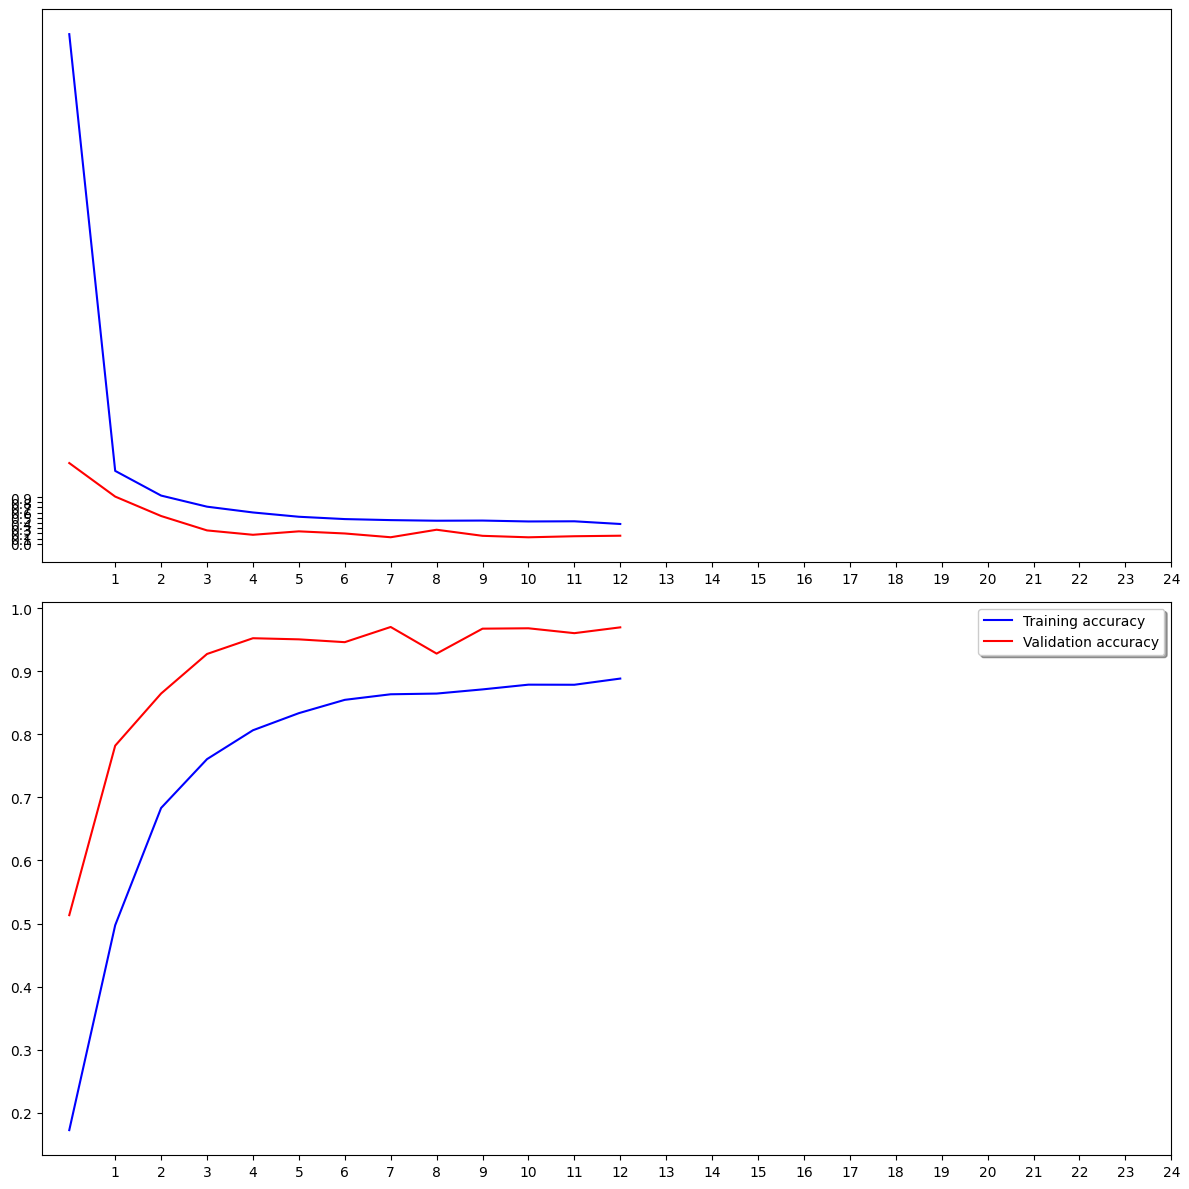

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Testing Accuracy

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

best_model_path = 'model/self_trained/distracted-08-0.97.hdf5'

# Load the model
model = load_model(best_model_path)

# Constants
IMAGE_SIZE = 224  # as used in your training
BATCH_SIZE = 64   # as used in your training

# Load the test data
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))
X_test = []
y_test = []

for i, row in data_test.iterrows():
    image_path = row['FileName']
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    X_test.append(img.astype(np.float32))
    #y_test.append(labels_id[row['ClassName']]) # Assuming 'ClassName' is the column name

# Convert lists to NumPy arrays
X_test = np.array(X_test)
#y_test = np.array(y_test)

# Preprocess X_test as done with X_train
X_test = X_test / 255.0  # If you normalized training data

# Convert labels to categorical (one-hot encoding)
y_test = to_categorical(y_test, num_classes=len(labels_id))

# Load the best model
best_model_path = 'model/self_trained/distracted-22-0.99.hdf5'
model = load_model(best_model_path)
predictions = model.predict(X_test)





In [42]:
test_df

,Filename,ClassName
12922,/scratch/user/gjoshi/Distracted Driver/state-f...,6
17403,/scratch/user/gjoshi/Distracted Driver/state-f...,3
7648,/scratch/user/gjoshi/Distracted Driver/state-f...,9
15371,/scratch/user/gjoshi/Distracted Driver/state-f...,8
9213,/scratch/user/gjoshi/Distracted Driver/state-f...,2
...,...,...
2540,/scratch/user/gjoshi/Distracted Driver/state-f...,5
13706,/scratch/user/gjoshi/Distracted Driver/state-f...,6
2912,/scratch/user/gjoshi/Distracted Driver/state-f...,5
1038,/scratch/user/gjoshi/Distracted Driver/state-f...,0


In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image

# Assuming 'model' is already loaded with your trained deep learning model

# Load test data
#test_data = pd.read_csv("test_data.csv")  # assuming your test data is in a CSV file
file_paths = test_df['Filename'].tolist()
true_labels = test_df['ClassName'].tolist()

# Function to preprocess images (assuming image data)
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # adjust target_size as per your model's input shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Make predictions
predicted_labels = []
for file_path in file_paths:
    preprocessed_img = preprocess_image(file_path)
    prediction = model.predict(preprocessed_img)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Assuming it's a classification task
    predicted_labels.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)


1/1 [==============================] - 0s 19ms/step
Accuracy: 0.9793078844095612
